In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import helper

In [31]:
data = pd.read_csv('../input/preprocessed_data.csv')
data = helper.remove_outliers_z_score(data)
# drop data with revenue = 0
data = data[data['revenue'] != 0]
X = data.drop('revenue', axis=1)
X = helper.data_standardizer(X,8)

y = data['revenue']
y = y.apply(helper.revenue_log)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training fold 1...
Fold 1 trained. validation loss: 1.5582736730575562
Training fold 2...
Fold 2 trained. validation loss: 1.3857853412628174
Training fold 3...
Fold 3 trained. validation loss: 1.4175459146499634
Training fold 4...
Fold 4 trained. validation loss: 1.6709758043289185
Training fold 5...
Fold 5 trained. validation loss: 2.1912896633148193
15/15 [==============================] - 0s 351us/step


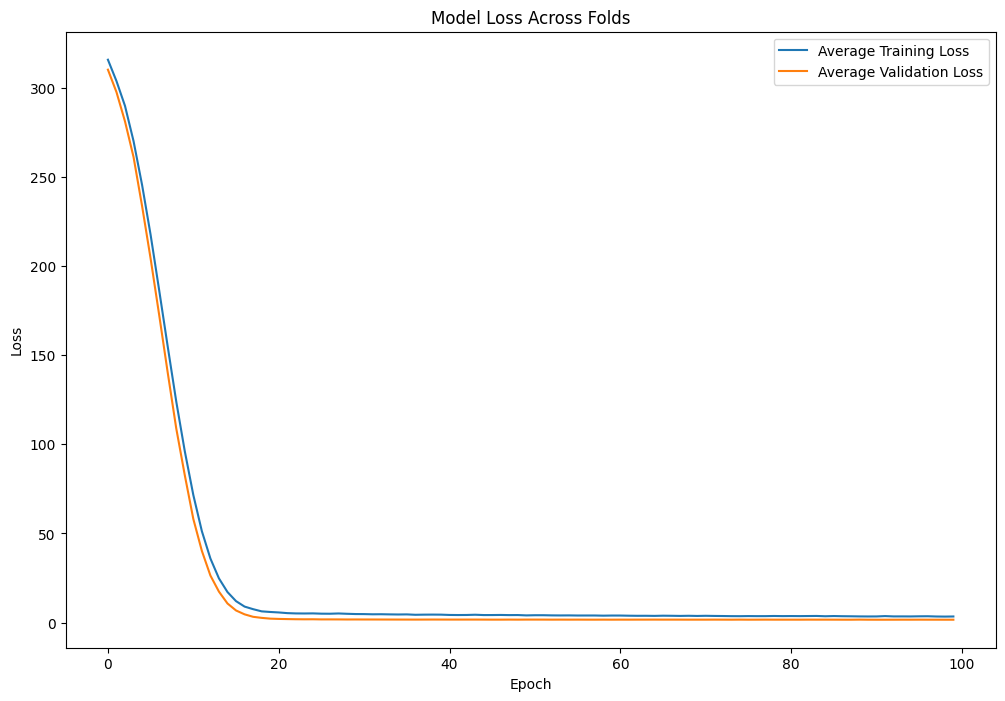

In [32]:


def create_model(input_dim):
    model = Sequential([
        Dense(100, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(50, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(20, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(1) 
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_no = 1
losses = []
val_losses = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    model = create_model(X_train.shape[1])

    print(f'Training fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, 
                        epochs=100, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold), 
                        verbose=0)

    losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    print(f'Fold {fold_no} trained. validation loss: {history.history["val_loss"][-1]}')
    
    fold_no += 1

avg_loss = np.mean(losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)

preds = model.predict(X_test)

# plt.scatter(y_test, preds)
# plt.xlabel('True Revenue')
# plt.ylabel('Predicted Revenue')
# plt.axis('equal')
# plt.title('True vs Predicted Revenue')
# plt.show()


plt.figure(figsize=(12, 8))
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [33]:


# model = Sequential([
#     Dense(12, activation='relu', input_shape=(X_train.shape[1],)),
#     BatchNormalization(),
#     Dropout(0.2),
#     Dense(2, activation='relu'),
#     BatchNormalization(),
#     Dense(1)  # No activation for output layer
# ])

# optimizer = Adam(learning_rate=0.005)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# history = model.fit(
#     X_train, y_train,
#     epochs=150,
#     batch_size=128,  
#     validation_data=(X_test, y_test),
#     callbacks=[early_stopping, reduce_lr]
# )

# test_loss = model.evaluate(X_test, y_test)
# print(f'Test loss: {test_loss}')
# predictions = model.predict(X_test)

# plt.scatter(y_test, predictions)
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([10,plt.xlim()[1]])
# plt.ylim([10,plt.ylim()[1]])


# _ = plt.plot([-100, 100], [-100, 100])



Epoch 1/20
57/57 [==============================] - 2s 19ms/step - loss: 312.3344 - val_loss: 296.9619 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - 1s 18ms/step - loss: 290.9746 - val_loss: 244.5001 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - 1s 19ms/step - loss: 259.7198 - val_loss: 227.8175 - lr: 0.0010
Epoch 4/20
57/57 [==============================] - 1s 19ms/step - loss: 219.9960 - val_loss: 173.4458 - lr: 0.0010
Epoch 5/20
57/57 [==============================] - 1s 21ms/step - loss: 175.6965 - val_loss: 130.9287 - lr: 0.0010
Epoch 6/20
57/57 [==============================] - 1s 19ms/step - loss: 131.4557 - val_loss: 100.0329 - lr: 0.0010
Epoch 7/20
57/57 [==============================] - 1s 20ms/step - loss: 91.2395 - val_loss: 60.4116 - lr: 0.0010
Epoch 8/20
57/57 [==============================] - 1s 19ms/step - loss: 58.4627 - val_loss: 39.7895 - lr: 0.0010
Epoch 9/20
57/57 [==============================] - 1s 20ms/step - loss: 34.

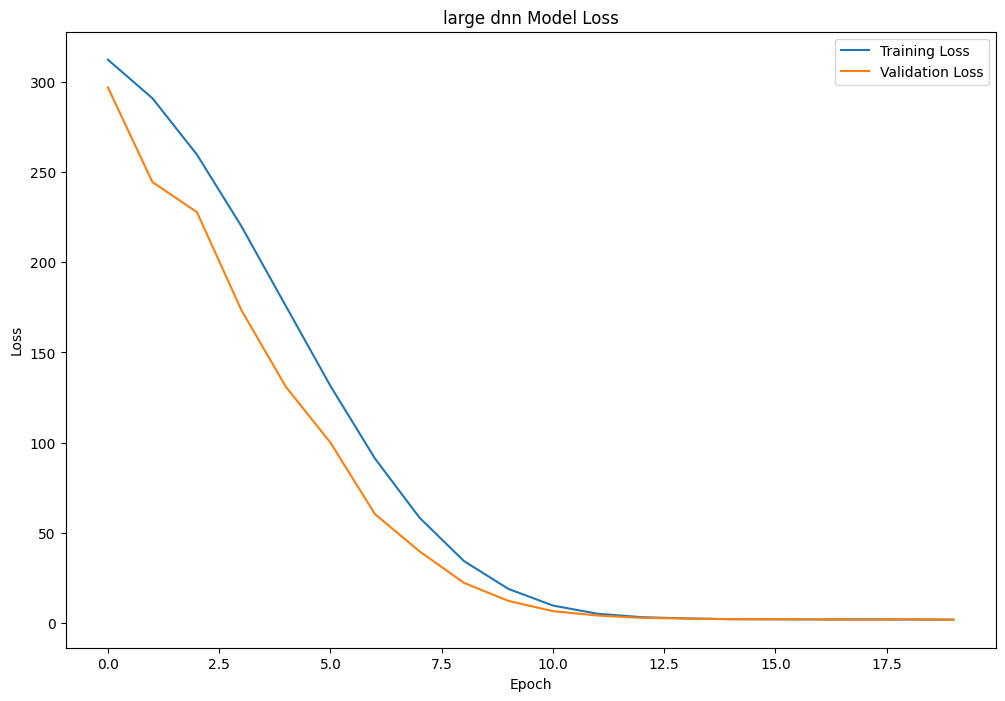

[1.0158887]


In [41]:

model = Sequential([
    Dense(4000, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(2000),
    LeakyReLU(alpha=0.05),
    BatchNormalization(),
    Dropout(0.4),
    Dense(2000),
    LeakyReLU(alpha=0.05),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1000),
    LeakyReLU(alpha=0.05),
    BatchNormalization(),
    Dropout(0.3),
    Dense(250, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(50, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(50, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(25, activation='relu'),
    BatchNormalization(),
    Dense(1)  # No activation for output layer
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,  
    validation_data=(X_test, y_test),
    callbacks=[ early_stopping, reduce_lr] #! early_stopping,
)

test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')
predictions = model.predict(X_test)
if (0):
    plt.scatter(y_test, predictions)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([10,plt.xlim()[1]])
    plt.ylim([10,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])
else:
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('large dnn Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

ratio = 0
for i in range(len(predictions)):
    ratio += predictions[i]/ y_test.iloc[i]
print(ratio/len(predictions))